Import needed packages

In [ ]:

"""
Import needed packages
"""

import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plotter_lib
import PIL as image_lib
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import urllib.request
import tarfile
import scipy


Code configuration

In [ ]:


""" Code configuration"""
# Training Data URL
url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
save_path = './food-101.tar.gz'

# The path of downloaded Data the path of splitting data to training, validation and testing
# images_path = './food-101/images'
# images_split_dir='./food-101/data_split'
images_path = r'/content/food-101/images'
images_split_dir=r'/content/food-101/data_split'

# Number of images categories/classes
classes_number=101

skip_download=False

skip_data_split=False

Skip_model_training=False

Skip_load_model=False


Data Download and Extraction

In [ ]:

# ************************************************************** #
# ************************************************************** #

"""Data Download and Extraction"""

# Download and extract the data using shell commands in Jupyter
# Download the dataset
# !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -O /content/food-101.tar.gz

# Extract the dataset
# !tar -xzvf /content/food-101.tar.gz -C /content/

# ************************************************************** #

# Download and extract the data using python code
# Download the dataset
if not skip_download:
    urllib.request.urlretrieve(url, save_path)

    # Extract the dataset
    with tarfile.open(save_path, 'r:gz') as tar:
        tar.extractall('./')


Splitting the images data to 70% training and 15% validation and 15% testing


In [ ]:

"""Splitting the images data to 70% training and 15% validation and 15% testing"""

# Create train, validation, and test directories
train_dir = os.path.join(images_split_dir, 'train')
val_dir = os.path.join(images_split_dir, 'val')
test_dir = os.path.join(images_split_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


if not os.path.exists(images_split_dir):
    os.makedirs(images_split_dir)

classes = [d for d in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, d))]

i=0
if not skip_data_split:
    for cls in classes:
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
        # Get all images in class directory
        images = os.listdir(os.path.join(images_path, cls))
        np.random.shuffle(images)

        # Split images into train, val, and test
        train_images = images[:int(0.7 * len(images))]
        val_images = images[int(0.7 * len(images)):int(0.85 * len(images))]
        test_images = images[int(0.85 * len(images)):]

        # copy images to respective directories
        for img in train_images:
            shutil.copy(os.path.join(images_path, cls, img), os.path.join(train_dir, cls))

        for img in val_images:
            shutil.copy(os.path.join(images_path, cls, img), os.path.join(val_dir, cls))

        for img in test_images:
            shutil.copy(os.path.join(images_path, cls, img), os.path.join(test_dir, cls))
        if i ==classes_number-1:
            break
        i=i+1


Show sample of images

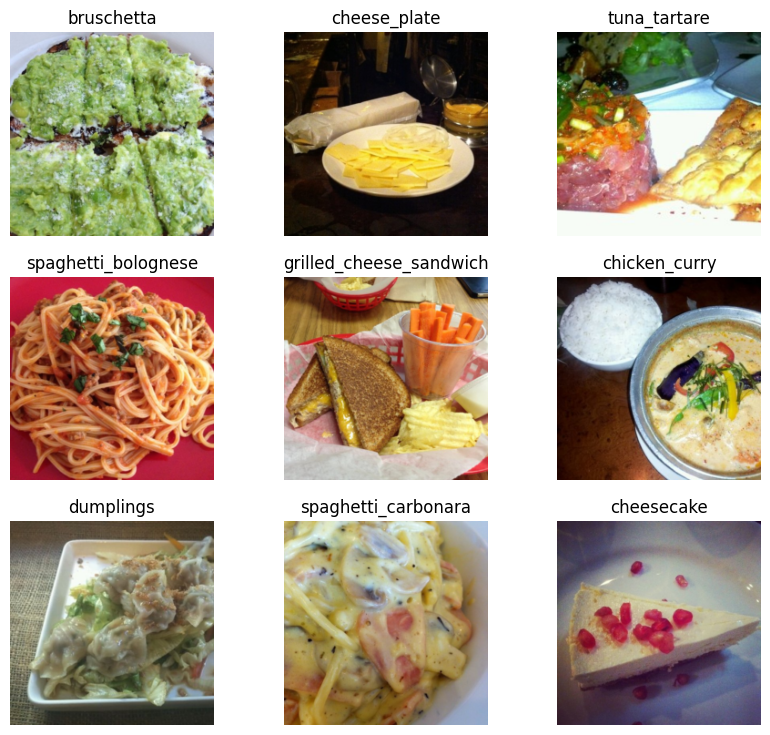

In [ ]:
from fastai.vision.all import ImageDataLoaders, Resize

def display_batch(images_path):
    # Specify a standard size for all images
    standard_size = 224

    # Create a DataLoaders object with the Resize transform
    data = ImageDataLoaders.from_folder(
        images_path,
        valid_pct=0.2,
        seed=42,
        bs=20,  # Batch size set to 20
        item_tfms=Resize(standard_size)  # Resize transform
    )

    # Show a batch of images, the layout will depend on the batch size
    data.show_batch(figsize=(10,9))

display_batch(images_path)


Data Preprocessing and Augmentation: We'll use TensorFlow and Keras for preprocessing.


In [ ]:

"""
Data Preprocessing and Augmentation: We'll use TensorFlow and Keras for preprocessing.
"""

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Data generators
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)


Found 70700 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.
Found 15150 images belonging to 101 classes.


Model Training: Using a pre-trained model (ResNet50) with fine-tuning.

In [ ]:
if not Skip_model_training:
    customized_resnet_model = Sequential()

    pretrained_resnet_model= tf.keras.applications.ResNet50(include_top=False,
                    #    input_shape=(180,180,3),
                    pooling='avg',classes=classes_number,
                    weights='imagenet')

    for each_layer in pretrained_resnet_model.layers:
            each_layer.trainable=False

    customized_resnet_model.add(pretrained_resnet_model)
    customized_resnet_model.add(Flatten())
    customized_resnet_model.add(Dense(512, activation='relu'))
    customized_resnet_model.add(Dense(classes_number, activation='softmax'))

    # Compile the model

    customized_resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

    # Train the model
    history = customized_resnet_model.fit(train_generator, validation_data=val_generator, epochs=10)

    # Save the model
    customized_resnet_model.save('customized_resnet_model.h5')


In [ ]:
if not Skip_model_training:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title

Load the model

In [ ]:
from keras.models import load_model

if not Skip_load_model:
    customized_resnet_model = load_model('/content/customized_resnet_model.h5')

# Evaluate on test and val datasets
customized_resnet_model.evaluate(val_generator)
customized_resnet_model.evaluate(test_generator)



474/474 [==============================] - 76s 160ms/step - loss: 1.1513 - accuracy: 0.7003


[1.1512598991394043, 0.7003300189971924]

Evaluation and Metrics

In [ ]:


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Predict classes on the test set
Y_pred = customized_resnet_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_generator.classes






474/474 [==============================] - 68s 141ms/step


In [ ]:

#   # Display the top 5 predicted classes and their confidence scores
# top_classes = 5
# predicted_classes = np.argsort(Y_pred[0])[:top_classes]
# confidence_scores = Y_pred[0][predicted_classes]
# Y_pred[0]
# # for i in range(top_classes):
# #     class_index = predicted_classes[i]
# #     class_confidence = confidence_scores[i]
# #     print(f"Class: {class_index}, Confidence: {class_confidence}")


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[ 70   0   8 ...   1   0   4]
 [  0 106   0 ...   0   0   0]
 [  2   0 110 ...   1   1   0]
 ...
 [  0   0   5 ... 106   0   3]
 [  1   0   0 ...   0  71   1]
 [  2   0   0 ...   1   0 126]]


In [ ]:
# Classification Report (Precision, Recall, F1-Score)
cr = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", cr)

Classification Report:
                          precision    recall  f1-score   support

              prime_rib       0.63      0.47      0.54       150
           french_fries       0.72      0.71      0.71       150
            onion_rings       0.67      0.73      0.70       150
          club_sandwich       0.55      0.80      0.65       150
         fish_and_chips       0.55      0.65      0.60       150
                mussels       0.71      0.51      0.59       150
            carrot_cake       0.83      0.84      0.84       150
               bibimbap       0.80      0.91      0.85       150
                baklava       0.61      0.38      0.47       150
         chocolate_cake       0.71      0.59      0.64       150
               macarons       0.65      0.53      0.58       150
              foie_gras       0.86      0.72      0.78       150
                churros       0.91      0.67      0.77       150
             bruschetta       0.80      0.63      0.70       150


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import numpy as np

def classification_report_to_dataframe(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split()
        if len(row_data) == 5:  # Expected number of columns
            row['class'] = row_data[0]
            row['precision'] = float(row_data[1])
            row['recall'] = float(row_data[2])
            row['f1_score'] = float(row_data[3])
            row['support'] = float(row_data[4])
            report_data.append(row)
        elif len(row_data) > 5:  # Handle class names with spaces
            row['class'] = ' '.join(row_data[0:-4])
            row['precision'] = float(row_data[-4])
            row['recall'] = float(row_data[-3])
            row['f1_score'] = float(row_data[-2])
            row['support'] = float(row_data[-1])
            report_data.append(row)
    return pd.DataFrame.from_dict(report_data)

# Convert report to DataFrame
df_report = classification_report_to_dataframe(cr)





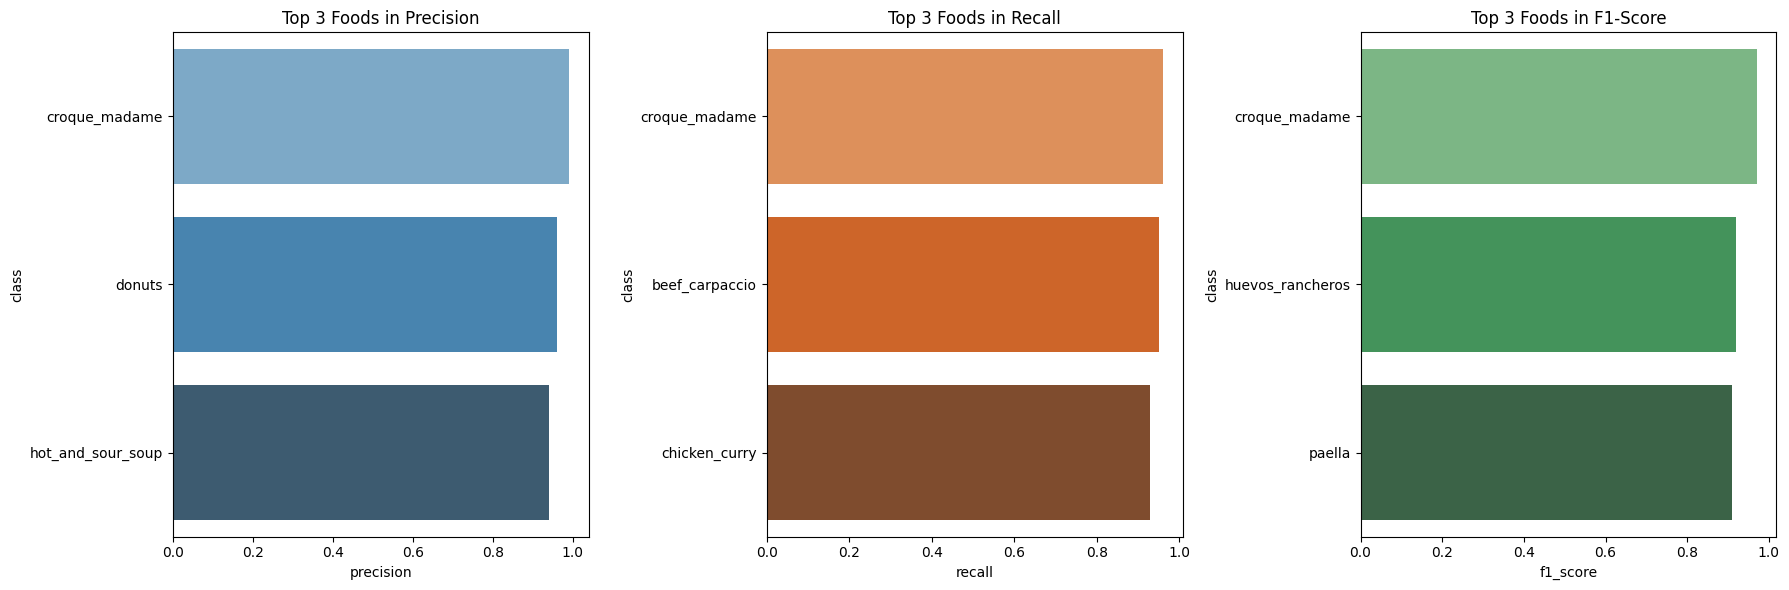

In [ ]:
# Finding top 3 in Precision, Recall, F1-Score
top_precision = df_report.nlargest(3, 'precision')
top_recall = df_report.nlargest(3, 'recall')
top_f1_score = df_report.nlargest(3, 'f1_score')
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(ax=axes[0], x='precision', y='class', data=top_precision, palette='Blues_d')
axes[0].set_title('Top 3 Foods in Precision')

sns.barplot(ax=axes[1], x='recall', y='class', data=top_recall, palette='Oranges_d')
axes[1].set_title('Top 3 Foods in Recall')

sns.barplot(ax=axes[2], x='f1_score', y='class', data=top_f1_score, palette='Greens_d')
axes[2].set_title('Top 3 Foods in F1-Score')

plt.tight_layout()
plt.show()

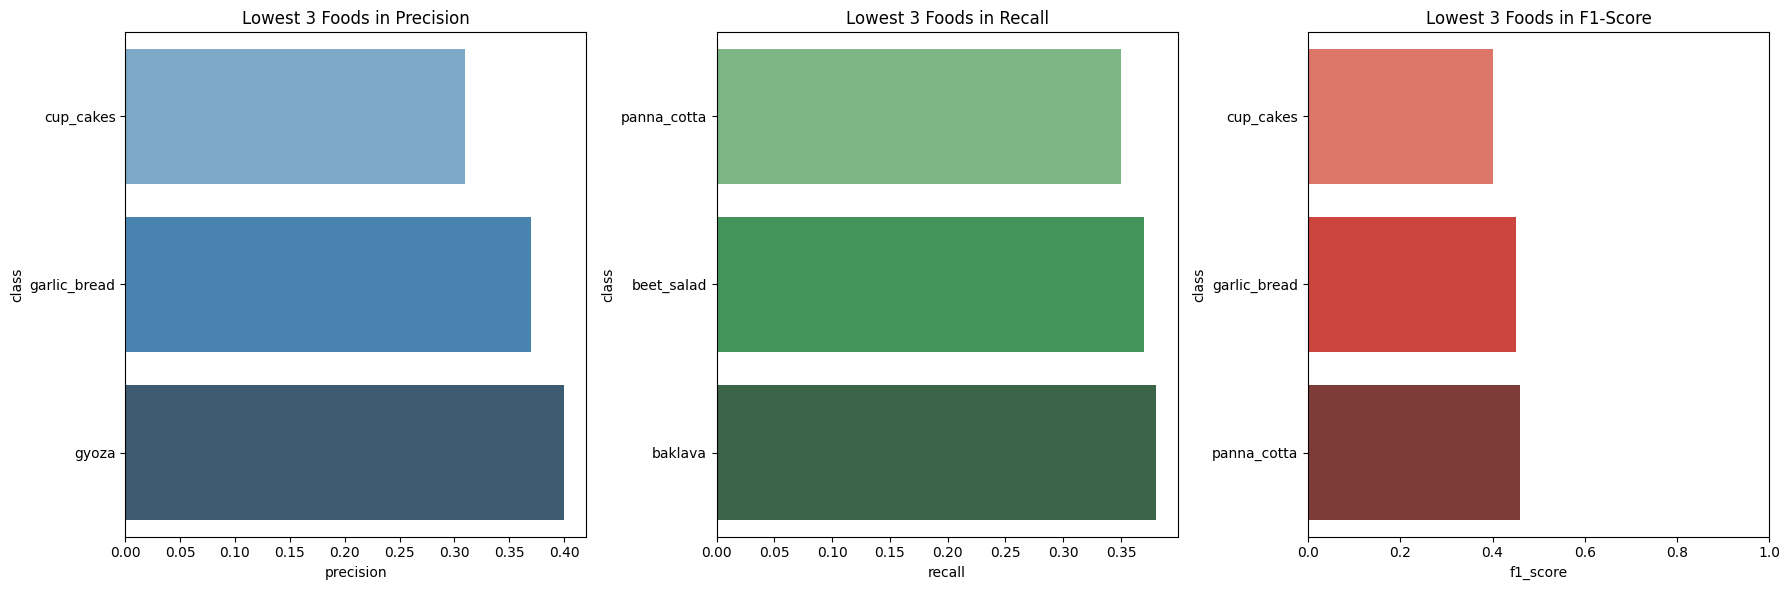

In [ ]:
# Finding top 3 in Precision, Recall, F1-Score
top_precision = df_report.nsmallest(3, 'precision')
top_recall = df_report.nsmallest(3, 'recall')
top_f1_score = df_report.nsmallest(3, 'f1_score')
# Plotting


fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(ax=axes[0], x='precision', y='class', data=top_precision, palette='Blues_d')
axes[0].set_title('Lowest 3 Foods in Precision')
plt.xlim(0, 1)

sns.barplot(ax=axes[1], x='recall', y='class', data=top_recall, palette='Greens_d')
axes[1].set_title('Lowest 3 Foods in Recall')
plt.xlim(0, 1)

sns.barplot(ax=axes[2], x='f1_score', y='class', data=top_f1_score, palette='Reds_d')
axes[2].set_title('Lowest 3 Foods in F1-Score')
plt.xlim(0, 1)

plt.tight_layout()
plt.show()